In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.odr as odr

from suncal import curvefit
np.random.seed(428530)

# Curve-Fitting Methods used by PSL Uncertainty Calculator

This notebook illustrates the various curve-fitting uncertainty methods used by the PSL Uncertainty Calculator. For actual examples of using the calculator to compute uncertainty in curve fits, see the `ArrayTutorial` and `ArrayCurveFitExamples` notebooks.

The Uncertainty Calculator implmenets four methods for determining uncertainty in a curve-fitting problem:

1. Least-Squares Analytical Method
2. Monte Carlo
3. Markov-Chain Monte Carlo
4. GUM Approximation

## Least-Squares Analytical Method

The least-squares solution finds the least-squares curve fit using one of several algorithms, depending on if the fitting is to a straight line and if there's uncertainty in x, y, both, or neither.

All these methods generate a covariance matrix to provide uncertainty in the fit parameters.

### Basic Least-Squares

The basic least-squares algorighm implemented by Numpy, Matlab, etc. Takes x, y data but does not consider uncertiainty in x or y. Covariance is returned. In this case, **uncertainty in the y data is estimated** based on the average residuals from a fit line having no uncertainty.

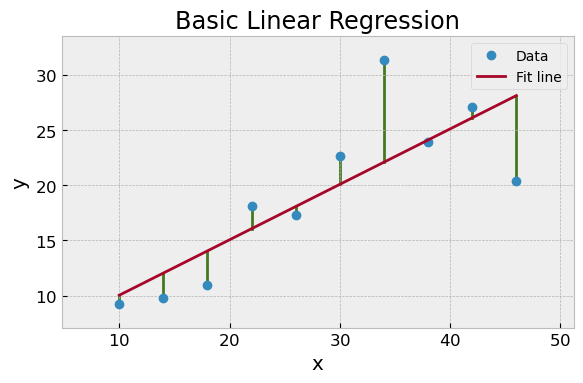

In [2]:
a, b = 3, .5
x = np.arange(10,50,4)
uy = np.linspace(1, 6, num=len(x))
y = a + b * x + np.random.normal(scale=uy, size=len(x))

# With no uncertainty in x or y, np.polyfit can be used.
coeff = np.polyfit(x, y, deg=1)

plt.plot(x, y, marker='o', ls='', label='Data')
xx = np.linspace(x.min(), x.max())
plt.plot(xx, np.poly1d(coeff)(xx), label='Fit line')
for xpoint, ypoint in zip(x, y):
    plt.plot([xpoint, xpoint], [ypoint, np.poly1d(coeff)(xpoint)], color='C3', zorder=0)
    
plt.legend(fontsize=10)
plt.title('Basic Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal');
plt.tight_layout()

### Linear least-squares with u(y) > 0

With uncertainty only in the y measurements, the 'linefit' algorithm described in [1] is used. Note that adding an uncertainty to the y points may actually reduce the uncertainty in the slope and intercept, because u(y) is no longer being estimated based on residuals.

#### References

[1] Numerical Recipes in C, The Art of Scientific Computing. Second Edition.
    W. H. Press, S. A. Teukolsky, W. T. Vetterling, B. P. Flannery.
    Cambridge University Press. 2002.

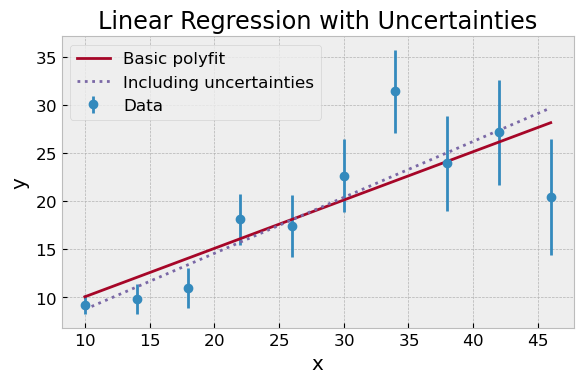

In [3]:
coeff1, _ = curvefit.linefit(x, y, sig=uy)

plt.errorbar(x, y, yerr=uy, marker='o', ls='', label='Data')
plt.plot(xx, np.poly1d(coeff)(xx), label='Basic polyfit')
plt.plot(xx, np.poly1d(coeff1)(xx), ls=':', label='Including uncertainties')
plt.title('Linear Regression with Uncertainties')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();
plt.tight_layout()

### Linear regression with u(x) and u(y) > 0

Uncertainty in both x and y measurements can be handled using the algorithm described by York [1] and Wehr [2]. This can also handle correlations between u(x) and u(y).

#### References

[1] York, Evensen. Unified equations for the slope, intercept, and standard
        errors of the best straight line. American Journal of Physics. 72, 367 (2004)
        
[2] Wehr, Saleska. The long-solved problem of the best-fit straight line:
        application to isotopic mixing lines. Biogeosciences. 14, 17-29 (2017)

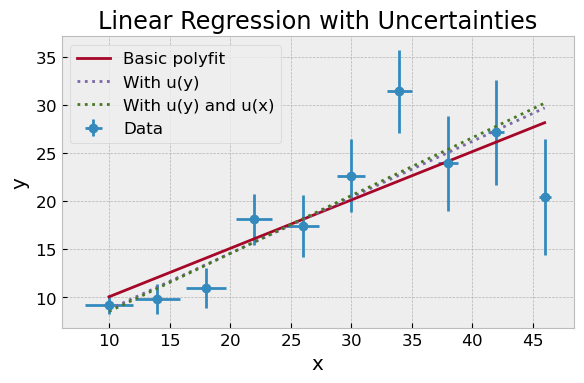

In [4]:
ux = np.linspace(2, .5, num=len(x))
coeff2, _ = curvefit.linefitYork(x, y, sigx=ux, sigy=uy)

plt.errorbar(x, y, xerr=ux, yerr=uy, marker='o', ls='', label='Data')
plt.plot(xx, np.poly1d(coeff)(xx), label='Basic polyfit')
plt.plot(xx, np.poly1d(coeff1)(xx), ls=':', label='With u(y)')
plt.plot(xx, np.poly1d(coeff2)(xx), ls=':', label='With u(y) and u(x)')
plt.title('Linear Regression with Uncertainties')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();
plt.tight_layout()

### Non-linear regression

For non-linear curve fitting, the least-squares algorighm implemented by scipy.curve_fit is used when u(x) = 0. For u(x) > 0, an Orthogonal Distance Regression (as implemented by scipy.odr) is used. The idea is the same as least-squares, except for minimizing the shortest orthogonal distances to the fit line instead of the vertical distances.

#### References

[1] P. T. Boggs and J. E. Rogers, “Orthogonal Distance Regression,” in “Statistical analysis of measurement error models and applications: proceedings of the AMS-IMS-SIAM joint summer research conference held June 10-16, 1989,” Contemporary Mathematics, vol. 112, pg. 186, 1990.

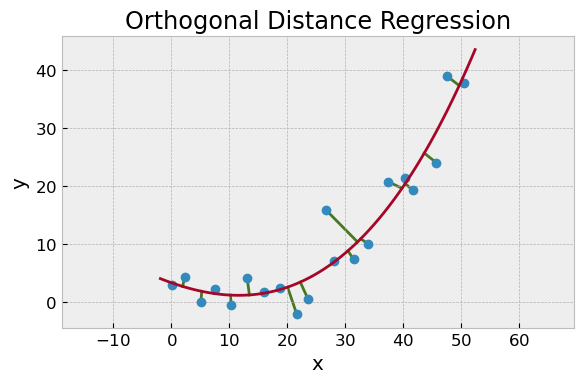

In [5]:
xo = np.linspace(0, 50, num=20)
yo = .0005 * xo**3 -.01 * xo**2 - .05 * xo + 3
uxo = np.linspace(.1, 1, num=len(xo))
uyo = np.linspace(1, 10, num=len(yo))
yo = yo + np.random.normal(scale=uyo)
xo = xo + np.random.normal(scale=uxo)

def odrfunc(B, x):
    return B[0] + B[1] * x + B[2] * x**2 + B[3] * x**3

# ODR implementation, same as used by uarray
model = odr.Model(odrfunc)
mdata = odr.RealData(xo, yo, sx=uxo, sy=uyo)
modr = odr.ODR(mdata, model, beta0=[.05, -.05, .2, 3])
mout = modr.run()

plt.plot(xo, yo, marker='o', ls='')
xx = np.linspace(xo.min()-2, xo.max()+2, num=100)
plt.plot(xx, odrfunc(mout.beta, xx))

# Get (approximate) orthoganal distances by brute-force
distances = np.array([(yo-odrfunc(mout.beta, z))**2 + (xo-z)**2 for z in xx])
xorth = xx[distances.argmin(axis=0)]
yorth = np.array([odrfunc(mout.beta, z) for z in xorth])

for xpoint, ypoint, xodr, yodr in zip(xo, yo, xorth, yorth):
    plt.plot([xpoint, xodr], [ypoint, yodr], color='C3', zorder=0)

plt.title('Orthogonal Distance Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal');
plt.tight_layout()

## Monte-Carlo Uncertainty Method

The Monte-Carlo method uses the same least-squares curve fitting algorithms as above, excluding ux and uy in the fitting algorithm, and the returned covariance values are ignored. Instead, each x, y point is sampled over its distribution N times, and N possible fit curves are calculated. The mean and total uncertainty in each parameter is taken from the size-N sample of each fit parameter.

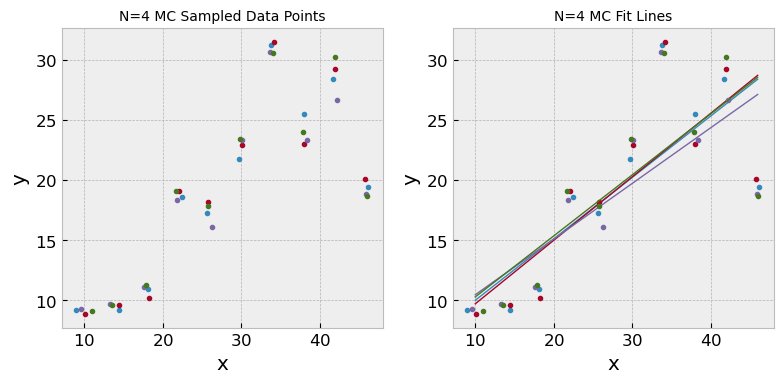

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
xx = np.linspace(x.min(), x.max(), num=10)

N = 4
for i in range(N):
    xsample = np.random.normal(loc=x, scale=ux/5)
    ysample = np.random.normal(loc=y, scale=uy/5)
    ax[0].plot(xsample, ysample, marker='.', ls='')
    
    # Fit line to this sample of points
    p = np.polyfit(xsample, ysample, deg=1)
    ax[1].plot(xsample, ysample, marker='.', ls='', color='C{}'.format(i))
    ax[1].plot(xx, np.poly1d(p)(xx), lw=1, color='C{}'.format(i))
       
    
ax[0].set_title('N={} MC Sampled Data Points'.format(N), fontsize=10)
ax[1].set_title('N={} MC Fit Lines'.format(N), fontsize=10)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
fig.tight_layout()

## Markov-Chain Monte-Carlo Method

Instead of taking random samples of each measured data point, this method takes random samples in the fit parameter distributions.

1) Baseline uncertainty in each fit parameter is found using least-squares methods described above

2) The space of fit parameters is explored using a random walk based on the probability that the measured data could come from those fit parameters.

3) Mean and uncertainty of each parameter is determined from the distribution of the random walk.

NOTE: This method cannot (currently) handle uncertainty in x or non-uniform uncertainty in y.

#### References

[1] C. Elster, B. Toman. "Bayesian uncertainty analysis for a regression model versus
    application of GUM Supplement 1 to the least-squares estimate", Metrologia 48 (2011) 233-240.
    
[2] T. Iamsasri, et. al. "A Bayesian approach to modeling diffraction profiles
    and application to ferroelectric materials." J. Appl. Crystallography (2017). 50, 211-220.

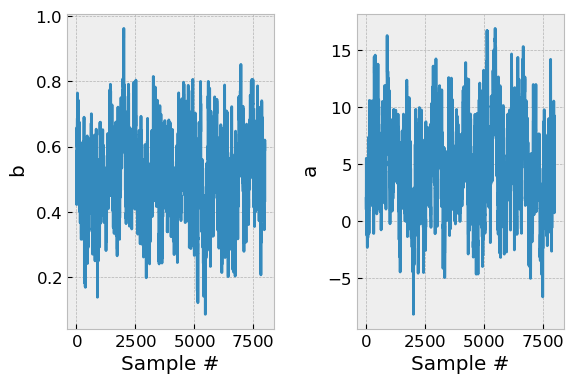

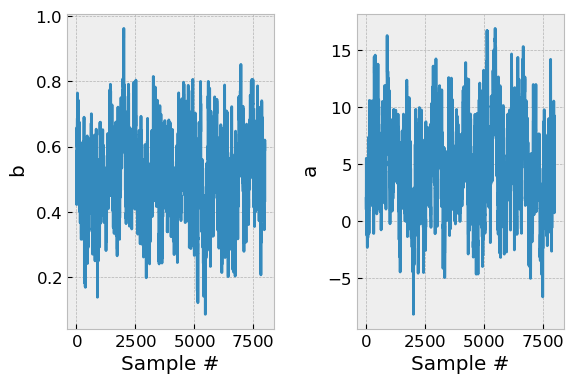

In [7]:
arr = curvefit.Array(x, y)
fit = curvefit.CurveFit(arr)
out = fit.calculate(mcmc=True, lsq=False, samples=50000).mcmc
out.plot_samples()

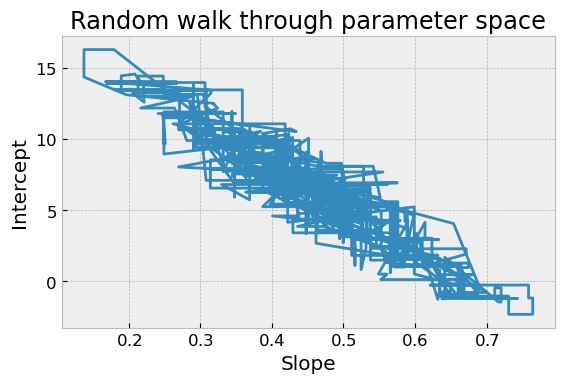

In [8]:
plt.plot(out.samples[:1000,0], out.samples[:1000,1])
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Random walk through parameter space');
plt.tight_layout()

## GUM Method

The GUM assumes a model in the form of $y = f(x1, x2, x3...)$. For curve fitting, we can take the function f to be one of the least-squares curve fit methods and *every* x and y data point to be a single input to the function $f$. To calculate a combined uncertainty, the gradient is numerically computed over all the measured data points, multiplied by the uncertainty of each measurement, and summed together.

$$u_c^2(y)=\sum \left(\frac{\partial f}{\partial x_i}\right)^2 u_{x_i}^2$$

This method assumes all x and y measurements are independent.

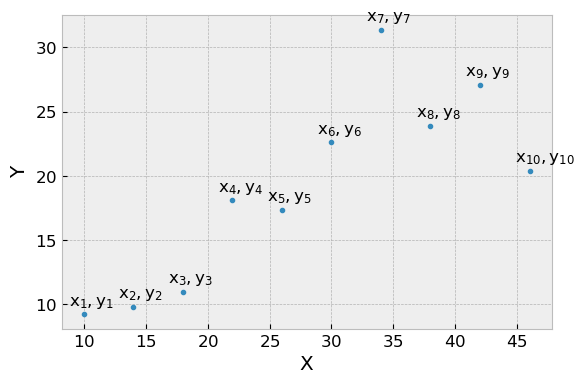

In [9]:
plt.plot(x, y, marker='.', ls='')
for i, (xpoint, ypoint) in enumerate(zip(x, y)):
    plt.text(xpoint-1.2, ypoint+.7, '$x_{{{}}}, y_{{{}}}$'.format(i+1, i+1))
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()

# All together using Calculator

The PSL's uncertainty calculator will compute all 4 methods for comparison. The calculate() method does not compute Markov-Chain by default. Enable it by passing `mcmc=True`.

In [10]:
arr = curvefit.Array(x, y, uy=uy)
fit = curvefit.CurveFit(arr)
fit.calculate(gum=True, mc=True, lsq=True, mcmc=True)

WARNING - MCMC algorithm with non-constant u(y). Using mean.


Method (k=1)              | b         | a        
-------------------------|---------|---------
Least Squares             | 0.582 ± 0.081 | 2.9 ± 1.5
GUM Approximation         | 0.50 ± 0.11 | 5.0 ± 2.4
Monte Carlo               | 0.51 ± 0.11 | 4.9 ± 2.5
Markov-Chain Monte Carlo  | 0.492 ± 0.092 | 5.3 ± 2.8